### 1.处理路网，分离出 G(V,E)
### 2.Compound HMM Process

In [1]:
import numpy as np
import pandas as pd
import requests
import os
from sklearn.neighbors import KDTree
from geopy.distance import geodesic
import time
import datetime
from datetime import datetime, datetime
import math

#### Section 1 
道路采样点间隔约为15m,因此投影点可以直接选取  
道路交叉点？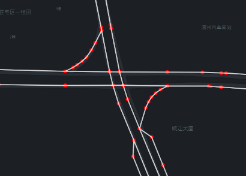  每个section都会被选中作为采样点，则只需要在所有的点集合中选择重复点集即可，为了之后距离计算的方便，可以考虑抽出交叉路口点

#### Section 2 
2.1. 降采样 频率越降低至1min

In [282]:
FilePath='E:/WorkSpace/py/travel_flow/data/extra_data/taxi-sample/'
FileName='taxi-20200309.csv'
dfs=pd.read_csv(FilePath+FileName,encoding='utf-8')
dfs.columns=['id','lng','lat','state','time']

dfs=dfs[(dfs['lng']>1) & (dfs['lat']>1)]
dfs=dfs[~(dfs['time'] =='2020/3/10')]
dfs=dfs[~(dfs['time'] =='2020/3/9')]

dfs['timestamp']=dfs['time'].apply(lambda x:int(time.mktime(datetime.strptime(x, "%Y/%m/%d %H:%M:%S").timetuple())))
dfs=dfs.sort_values(['id','timestamp']).reset_index(drop=True)

In [283]:
dfs

,id,lng,lat,state,time,timestamp
0,浙CT100053,120.65348,27.964222,1,2020/3/9 6:58:04,1583708284
1,浙CT100053,120.65348,27.964222,1,2020/3/9 6:58:05,1583708285
2,浙CT100053,120.65349,27.964212,1,2020/3/9 6:58:22,1583708302
3,浙CT100053,120.65351,27.964212,1,2020/3/9 6:58:26,1583708306
4,浙CT100053,120.65350,27.964230,1,2020/3/9 6:58:27,1583708307
...,...,...,...,...,...,...
6608929,浙CT99962,120.60259,27.996315,1,2020/3/9 23:04:19,1583766259
6608930,浙CT99962,120.60259,27.996315,1,2020/3/9 23:04:35,1583766275
6608931,浙CT99962,120.60259,27.996315,1,2020/3/9 23:04:49,1583766289
6608932,浙CT99962,120.60259,27.996315,1,2020/3/9 23:05:05,1583766305


In [287]:
groups = dfs.groupby('id')
taxi=groups.get_group('浙CT100053').sort_values(by=['timestamp'])

downsample=taxi[::2].copy()
downsample['lng']=(downsample['lng']-120)*85390
downsample['lat']=(downsample['lat']-28)*111000

In [356]:
taxi[::2].copy()

,id,lng,lat,state,time,timestamp
0,浙CT100053,120.65348,27.964222,1,2020/3/9 6:58:04,1583708284
2,浙CT100053,120.65349,27.964212,1,2020/3/9 6:58:22,1583708302
4,浙CT100053,120.65350,27.964230,1,2020/3/9 6:58:27,1583708307
6,浙CT100053,120.65325,27.964394,1,2020/3/9 6:58:39,1583708319
8,浙CT100053,120.65113,27.967564,1,2020/3/9 6:59:51,1583708391
...,...,...,...,...,...,...
1992,浙CT100053,120.65366,27.964280,1,2020/3/9 19:14:51,1583752491
1994,浙CT100053,120.65366,27.964280,1,2020/3/9 19:15:51,1583752551
1996,浙CT100053,120.65366,27.964280,1,2020/3/9 19:16:51,1583752611
1998,浙CT100053,120.65366,27.964280,1,2020/3/9 19:17:51,1583752671


In [240]:
with open("data/roads.json","r",encoding='utf-8') as f:
    road_list=json.load(f) 

MAXLAT=28.1
MINLAT=27.85
MAXLON=120.9
MINLON=120.5

threshold = 0.2

2.2 对于每一个匹配点$p^i$，选取3~5个投影点(即道路采样点) $c^i$，观测概率与距离相关，呈高斯分布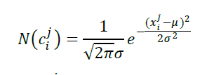但也首先只存储距离

In [241]:
# 建立投影点集以及路口点集合，如果有需要可以扩充投影点集
# 地图段出现大量重复！ 
PointSet = pd.DataFrame(columns=['lng','lat','id'])
Index=0
sumlist=[]

for x in road_list:
    polys=x['polylines']
    for i in polys:
        
        lists=[[float(x.split(',')[0]),float(x.split(',')[1])] for x in i.split(';')]
        df=pd.DataFrame(lists)
        lens=df.shape[0]
        LonInRange=((df[0]>MINLON) & (df[0]<MAXLON)).astype(int).sum()
        LatInRange=((df[1]>MINLAT) & (df[1]<MAXLAT)).astype(int).sum()
        
        if df[0].sum() in sumlist:
            continue
        else: 
            sumlist.append(df[0].sum())
            

        if((LonInRange/lens > threshold) and (LatInRange/lens > threshold)):
            df.columns=['lng','lat']
            Index+=1
            df['id']=Index
            PointSet=pd.concat([PointSet,df])

PointSet=PointSet.reset_index(drop=True)

In [242]:
PointSetT=PointSet.copy()
PointSetT['lng']=(PointSetT['lng']-120)*85390
PointSetT['lat']=(PointSetT['lat']-28)*111000
PointSetT

,lng,lat,id
0,52429.818638,-4818.04713,1
1,52444.352016,-4814.00784,1
2,52460.789591,-4808.45784,1
3,52473.102829,-4806.08466,1
4,52498.600283,-4801.82892,1
...,...,...,...
82659,48591.247812,-6219.60750,15090
82660,48596.584687,-6225.43500,15090
82661,48601.588541,-6230.24463,15090
82662,48607.591458,-6234.71571,15090


In [243]:
# 用于插值道路的ID判断，cross 为道路
copys=PointSetT.copy()
copys=copys.sort_values(['lng','lat']).reset_index(drop=True)

copysdf1 = copys.drop_duplicates(subset=['lng','lat'],keep='first')
copysdf2= copys.drop_duplicates(subset=['lng','lat'],keep=False)
crossing=pd.concat([copysdf1,copysdf2])
crossing=crossing.drop_duplicates(subset=['lng','lat'],keep=False)
crossing

,lng,lat,id
113,42679.655417,5824.47858,6155
134,42698.697387,4055.44716,6157
137,42699.124337,4300.04787,6159
140,42699.414663,4224.99966,6159
144,42699.670833,4103.20713,6158
...,...,...,...
82447,76840.394562,4713.33750,14456
82450,76840.539725,4253.95179,14235
82456,76845.424033,4252.19466,14235
82487,76872.253571,4346.79108,14439


In [247]:
diff=PointSetT.diff()

In [245]:
## 插值道路点
diff=PointSetT.diff()
InterpT=[]
for idx,row in PointSetT.iloc[:-1,:].iterrows():
    for i in range(0,3):
        if(crossing[(crossing['lng']==row['lng']) & (crossing['lat']==row['lat'])].empty): #前一个点不为路口点
            id = row['id']
        else:
            id = PointSetT['id'][idx+1]
        InterpT.append({'lng':row['lng']+diff['lng'][idx+1]/3*i,'lat':row['lat']+diff['lat'][idx+1]/3*i,'id':id})
InterpT.append({'lng':PointSet.iloc[-1,0],'lat':PointSet.iloc[-1,1],'id':PointSet.iloc[-1,2]})    
InterpT=pd.DataFrame(InterpT)
InterpT

KeyError: -1

In [ ]:
Interp=InterpT.copy()
Interp['lng']=Interp['lng']/85390+120
Interp['lat']=Interp['lat']/111000+28
Interp

In [318]:
Interp

,lng,lat,id
0,120.614004,27.956594,1
1,120.614061,27.956606,1
2,120.614118,27.956618,1
3,120.614174,27.956631,1
4,120.614239,27.956647,1
...,...,...,...
247984,120.569195,27.943858,15090
247985,120.569219,27.943845,15090
247986,120.569242,27.943831,15090
247987,120.569282,27.943814,15090


In [250]:
NonCrossingPoint = InterpT.drop_duplicates(subset=['lng','lat'],keep='first').copy()
NonCrossingPoint

,lng,lat,id
0,52429.818638,-4818.04713,1
1,52434.663097,-4816.70070,1
2,52439.507557,-4815.35427,1
3,52444.352016,-4814.00784,1
4,52449.831208,-4812.15784,1
...,...,...,...
247984,48603.589513,-6231.73499,15090
247985,48605.590486,-6233.22535,15090
247986,48607.591458,-6234.71571,15090
247987,48611.015597,-6236.65821,15090


In [341]:
# 需要保留重复的路口点
copys = Interp.copy().drop_duplicates(subset=['lng','lat'],keep=False)
Cross=Interp.copy().drop(copys.index).drop_duplicates(keep='first')
Cross

,lng,lat,id
0,120.614004,27.956594,1
30,120.615601,27.956811,2
39,120.671732,27.881574,3
40,120.672325,27.879727,3
41,120.672918,27.877880,3
...,...,...,...
247887,120.881369,28.034656,15086
247914,120.825211,27.992393,15087
247920,120.826764,27.992679,15088
247929,120.827057,27.992734,15089


In [251]:
PointCloud=np.array(NonCrossingPoint.loc[:,['lng','lat']])
tree = KDTree(PointCloud)

In [302]:
PointCloud

array([[52429.818638  , -4818.04713   ],
       [52434.66309733, -4816.7007    ],
       [52439.50755667, -4815.35427   ],
       ...,
       [48607.591458  , -6234.71571   ],
       [48611.015597  , -6236.65821   ],
       [48614.439736  , -6238.60071   ]])

In [440]:
#是否需要多重query 并取不同类型的
K=5
to_be_Matching = []
for idx,row in downsample.iloc[:,[1,2]].iterrows():
    dist,ind = tree.query(np.array(row).reshape(1, -1),k=K)
    #r=radius
    to_be_Matching.append({'idx':idx,'dist':dist,'matchPoint':ind,'transfer':np.zeros((K,K))})
to_be_Matching=pd.DataFrame(to_be_Matching)
to_be_Matching = to_be_Matching.astype('object')

In [441]:
to_be_Matching

,idx,dist,matchPoint,transfer
0,0,"[[23.423667068659093, 32.09346753030271, 34.97...","[[114298, 114299, 145924, 114297, 114296]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
1,2,"[[24.821352422141555, 32.73350525518383, 34.94...","[[114298, 114299, 145924, 114297, 114296]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
2,4,"[[23.71531009561821, 30.561037736153356, 36.85...","[[114298, 114299, 145924, 114297, 114296]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
3,6,"[[6.5961061241662655, 22.560223783165128, 32.8...","[[114298, 114297, 114296, 114299, 145924]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
4,8,"[[43.18657828750944, 43.58332005541728, 43.754...","[[47651, 47652, 47650, 47653, 47649]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
...,...,...,...,...
996,1992,"[[22.35179169344488, 31.260062877239896, 41.05...","[[114299, 114298, 114265, 145924, 114297]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
997,1994,"[[22.35179169344488, 31.260062877239896, 41.05...","[[114299, 114298, 114265, 145924, 114297]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
998,1996,"[[22.35179169344488, 31.260062877239896, 41.05...","[[114299, 114298, 114265, 145924, 114297]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."
999,1998,"[[22.35179169344488, 31.260062877239896, 41.05...","[[114299, 114298, 114265, 145924, 114297]]","[[0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0...."


In [444]:
to_be_Matching['transfer'][4]

array([[21634.42196449, 21638.30455383, 21630.54150831, 21638.30455383,
        21626.66318643],
       [21634.57287089, 21638.45513746, 21630.69273758, 21638.45513746,
        21626.81473867],
       [21634.4508977 , 21638.33274384, 21630.57118498, 21638.33274384,
        21626.69360682],
       [21634.27110697, 21638.15401909, 21630.39032793, 21638.15401909,
        21626.51168308],
       [49756.33237807, 49752.36553275, 49760.30014467, 49752.36553275,
        49764.26883232]])

In [442]:
def Road_Point_Dist(i,j):
    if(Interp.iloc[i,2]==Interp.iloc[j,2]): # 同一道路,直接计算
        return geodesic((Interp.iloc[i,1],Interp.iloc[i,0]), (Interp.iloc[j,1],Interp.iloc[j,0])).m
    else:
        df=pd.concat([Cross[Cross['id']==Interp.iloc[i,2]],Cross[Cross['id']==Interp.iloc[j,2]]])
        idx=df.drop_duplicates(subset=['lng','lat'],keep='first').index
        df=df.drop(idx)
        if(not df.empty):
            return geodesic((Interp.iloc[i,1],Interp.iloc[i,0]), (df.iloc[0,1],df.iloc[0,0])).m + geodesic((Interp.iloc[j,1],Interp.iloc[j,0]), (df.iloc[0,1],df.iloc[0,0])).m 
        else:
            return geodesic((Interp.iloc[i,1],Interp.iloc[i,0]), (Interp.iloc[j,1],Interp.iloc[j,0])).m * 3
        #非同一道路，计算图中的最短路径，复杂点考虑还有路的朝向
        #简单起见，只考虑转一个路口的，当跨越多个路口时，值设低，则任务转化为求公共路口
def Match_Point_Dist(i,j):
    return geodesic((taxi[::2]['lat'][i],taxi[::2]['lng'][i]), (taxi[::2]['lat'][j],taxi[::2]['lng'][j])).m

for idx,row in to_be_Matching.iloc[1:,[1,2]].iterrows():
    RoadIndex1 = to_be_Matching.iloc[idx-1,2][0]
    RoadIndex2 = to_be_Matching.iloc[idx,2][0]
    dist=np.zeros((K,K))
    for ii,i in enumerate(RoadIndex1):
        for jj,j in enumerate(RoadIndex2):
            idx_1=to_be_Matching.iloc[idx-1,0]
            idx_2=to_be_Matching.iloc[idx,0]
            dist[ii,jj]= abs(Road_Point_Dist(i,j)-Match_Point_Dist( idx_1, idx_2))
    to_be_Matching.iloc[idx,3]=dist

2.3 对于相邻两个投影点之间，计算转移概率，首先储存前后匹配点的差值和投影点差值间的绝对值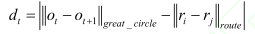

转移概率为：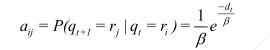

2.4 所有投影点计算完毕后，开始估计参数，用绝对中位差来估计$\mu$, $\beta$,公式如下：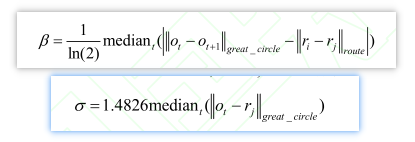

2.5 对于$c^i$,有$F(c^i_j)=argmax(N(c^{i-1}_k)*a_{jk})$ 求得最大$F(c)$后溯源找到对应路径